# Battle of Neighborhoods

### Introduction/Business Problem

<font size = 3> In this section let us discuss about New York city which is the largest and highly populated American city. The city has high international immigrants form all over the world. People of different ethnicity have been migrating to New York for years. The city has population in millions and is the commercial capital of the United States of America. The city has a high population density compared to most other largest cities in the world. There are large number of migrants from Asia who have made New York as their home. Majority of them are form India and China. As a result of This the city is diverse in culture. New York has several restaurants belonging to different categories such as chinese, Indian, Italian, French and so on.

So in this project let us analyze different areas of New York city with Indian restaurants and find out best neighborhoods for good indian restaurants. We will also visualize the neighborhoods based on ratings of various indian restaurants.<FONT>



### Data

<font size = 3> We need data of New York City with Boroughs, Neighbors and their latitudes and longitudes. Let us use data from the source https://cocl.us/new_york_dataset. This data source contians all neighborhoods location detials of the city of New Yok inclusing latitudes and logitudes.

Let us use Foursquare API to get Indian resturants in each neighborhood of new york city. By using Foursquare API we will get all the venues in each neighborhood of the city. We can filter thhose venues to get only indian resturants We can also extract features such as tips, ratings for each restaurant using this API.

We will use Geospace data from https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm to obtain the Borough boundaries of neighborhoods. Then we can visualize the data based on Borough boundaries.

Example: We will extract following details Collect the new york city data from https://cocl.us/new_york_dataset Using FourSquare API we will find all venues for each neighborhood. Filter out all venues with are Indian Resturants. Find rating , tips and count for each Indian Resturants using FourSquare API. Using rating for each resturant , we will sort that data.<font>

### Methodology/Approach

1.Abstarct the data from https://cocl.us/new_york_dataset<br>
2.Using FourSquare API find all venues for each neighborhood.<br>
3.Filter out all venues for Indian Resturants.<br>
4.Find rating , tips and counts for each Indian Resturants using FourSquare API.<br>
5.Sort that data using rating for each resturant.<br>
6.Visualize the Ranking of neighborhoods by importing folium.<br>

#### Analysis/Machine learnig technology used:
Pandas and Numpy are used for analysing data.<br> 
For working with FourSquare API request technique is used.<br>
Folium is used for data visualization.<br>
Geopy is used for getting New York city coordinates.
                                                                                                           


In [2]:
pip install geocoder



The following command must be run outside of the IPython shell:

    $ pip install geocoder

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [3]:
pip install geopy --user


The following command must be run outside of the IPython shell:

    $ pip install geopy --user

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [4]:
!pip install folium

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011


In [5]:
!pip install geocoder

     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011


In [12]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported')

Libraries imported


In [14]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Use FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Here we get venue id , venue name and category by below function

In [15]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Below function gives us venue details like like count , rating , tip counts for a given venue id which is used for ranking.

In [16]:
def get_venue_details(venue_id):
        
    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we have to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [17]:
def get_NewYork_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    NYdata = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        NYdata = NYdata.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return NYdata

In [18]:
NYdata=get_NewYork_data()

In [19]:
NYdata.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
NYdata.shape


(306, 4)

#### We got 306 different  neighborhoods in NewYork

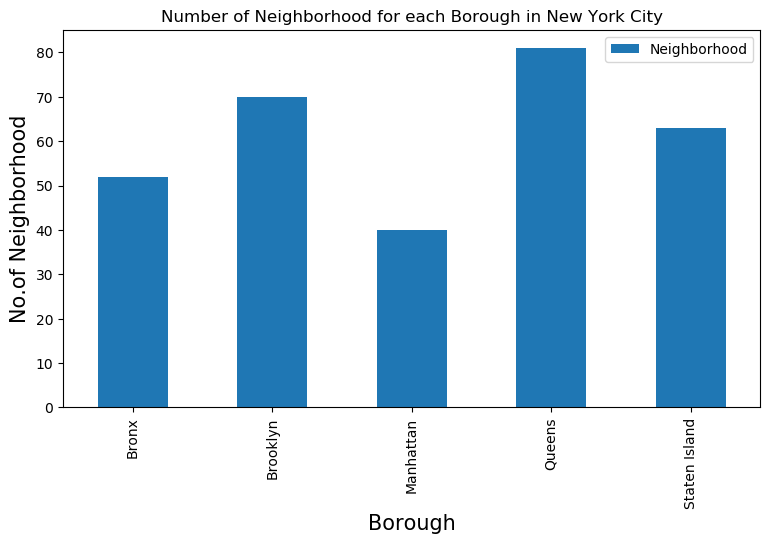

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
NYdata.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

#### We gave found that Queens has highest number of neighborhoods

#### Let us collect Indian resturants for each Neighborhood

In [16]:
indian_rest_ny.shape

(0, 4)

In [23]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [24]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    

In [ ]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [23]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


NameError: name 'indian_rest_stats_ny' is not defined

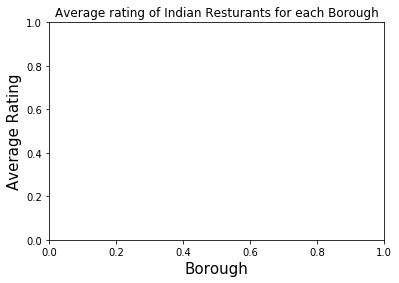

In [24]:
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Results/Conclusion:

Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.<br>
Manhattan have potential Indian Resturant Market/<br>
Staten Island ranks last in average rating of Indian Resturants.<br>
Manhattan is the best place to stay if you prefer Indian Cuisine.<br>

### Discussion

In [ ]:
The result is based on the rating provided. <br>
Based on the result i would recommed to use a more refined algorithm as accuracy beacuse the data provided is roughly based on our input.